,mask,opacity,acc_rank_delta,quality,final_score
0,circle,50,14.5680,0.451440,-14.116560
1,diamond,50,3.2664,0.497016,-2.769384
2,knit,50,0.6588,0.536120,-0.122680
3,square,50,5.0428,0.493961,-4.548839
4,circle,80,52.7168,0.314879,-52.401921
5,diamond,80,13.7152,0.360561,-13.354639
6,knit,80,2.0288,0.414305,-1.614495
7,square,80,22.0096,0.365297,-21.644303
8,circle,110,113.0692,0.205144,-112.864056
9,diamond,110,39.5536,0.258502,-39.295098


\begin{tabular}{rlrrr}
\toprule
opacity & mask & acc_rank_delta & quality & final_score \\
\midrule
50 & circle & 14.57 & 0.45 & -14.12 \\
50 & diamond & 3.27 & 0.50 & -2.77 \\
50 & knit & 0.66 & 0.54 & -0.12 \\
50 & square & 5.04 & 0.49 & -4.55 \\
80 & circle & 52.72 & 0.31 & -52.40 \\
80 & diamond & 13.72 & 0.36 & -13.35 \\
80 & knit & 2.03 & 0.41 & -1.61 \\
80 & square & 22.01 & 0.37 & -21.64 \\
110 & circle & 113.07 & 0.21 & -112.86 \\
110 & diamond & 39.55 & 0.26 & -39.30 \\
110 & knit & 3.62 & 0.32 & -3.30 \\
110 & square & 60.57 & 0.27 & -60.31 \\
140 & circle & 203.89 & 0.12 & -203.77 \\
140 & diamond & 90.79 & 0.18 & -90.60 \\
140 & knit & 5.47 & 0.24 & -5.23 \\
140 & square & 134.75 & 0.18 & -134.57 \\
170 & circle & 310.80 & 0.07 & -310.73 \\
170 & diamond & 188.92 & 0.12 & -188.80 \\
170 & knit & 9.21 & 0.18 & -9.03 \\
170 & square & 264.90 & 0.12 & -264.78 \\
\bottomrule
\end{tabular}



/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/ipykernel_64832/2243523974.py:145: UserWarning: AutoMinorLocator does not work on logarithmic scales
  plt.tight_layout()
/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/ipykernel_64832/2243523974.py:146: UserWarning: AutoMinorLocator does not work on logarithmic scales
  plt.savefig("./eval_cls_generalizability.pdf", format="pdf", dpi=300, bbox_inches="tight")
/Users/sueszli/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.canvas.print_figure(bytes_io, **kw)


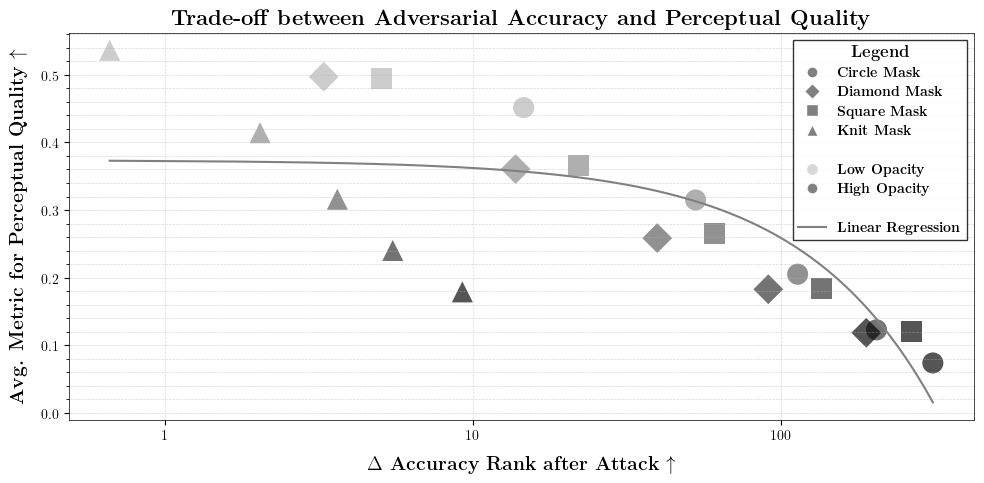

In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

datapath = Path.cwd().parent / "data" / "eval" / "eval_cls_generalizability.csv"
data = pd.read_csv(datapath)


"""
preprocessing
"""


def get_quality(cs, psnr, ssim, lpips):
    # weighted average metric:
    # - Cosine Similarity: already in the range [-1, 1], can be used as is.
    # - PSNR: normalize to [0, 1] by using a formula like: (PSNR - 30) / 20, clamped to [0, 1].
    # - SSIM: already in the range [-1, 1], can be used as is.
    # - LPIPS: invert and normalize to [0, 1] using: 1 - LPIPS, clamped to [0, 1].

    # create a boolean mask for valid entries
    valid_mask = ~(np.isnan(cs) | np.isnan(psnr) | np.isnan(ssim) | np.isnan(lpips) | np.isinf(cs) | np.isinf(psnr) | np.isinf(ssim) | np.isinf(lpips))

    # initialize with NaN
    wam = pd.Series(np.nan, index=cs.index)

    psnr_n = np.clip((psnr - 30) / 20, 0, 1)

    lpips_n = np.clip(lpips, 0, 1)

    wam[valid_mask] = 0.15 * cs[valid_mask] + 0.25 * psnr_n[valid_mask] + 0.35 * ssim[valid_mask] + 0.25 * (1 - lpips_n[valid_mask])

    return wam


data["acc_rank_delta"] = data["adv_acc_rank"] - data["acc_rank"]  # after - before (higher is better)
data["quality"] = get_quality(data["cosine_sim"], data["psnr"], data["ssim"], data["lpips"]) # higher is better
data["final_score"] = data["quality"] - data["acc_rank_delta"]  # higher is better

data = data.drop(columns=["model", "density", "img_id", "acc_rank", "adv_acc_rank", "cosine_sim", "psnr", "ssim", "lpips"])

data = data.groupby(["mask", "opacity"]).agg({"acc_rank_delta": "mean", "quality": "mean", "final_score": "mean"}).reset_index()


# sort by opacity first, then mask
data = data.sort_values(by=["opacity", "mask"])

data = data.reset_index(drop=True)
display(data)

data = data[["opacity", "mask", "acc_rank_delta", "quality", "final_score"]]

# print(data.to_csv(index=False, float_format="%.2f"))

# print as latex table
print(data.to_latex(index=False, float_format="%.2f"))

"""
plot
"""


plt.figure(figsize=(10, 7))

adv_acc = data["acc_rank_delta"]  # x-axis
quality = data["quality"]  # y-axis

plt.gca().invert_xaxis()

mask = data["mask"]  # "mask": ["circle", "square", "diamond", "knit"],
opacity = data["opacity"]  # "opacity": [50, 80, 110, 140, 170],

markers = {"circle": "o", "square": "s", "diamond": "D", "knit": "^"}

for mask in markers:
    mask_data = data[data["mask"] == mask]
    plt.scatter(mask_data["acc_rank_delta"], mask_data["quality"], marker=markers[mask], c="black", alpha=mask_data["opacity"] / 255, s=230, edgecolors="none")

# polynomial regression
x = data["acc_rank_delta"].values.reshape(-1, 1)
y = data["quality"].values
degree = 1
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(x, y)
x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)
plt.plot(x_smooth, y_smooth, color="gray")


plt.title(r"\textbf{Trade-off between Adversarial Accuracy and Perceptual Quality}")
plt.xlabel(r"\textbf{$\Delta$ Accuracy Rank after Attack} $\uparrow$")
plt.ylabel(r"\textbf{Avg. Metric for Perceptual Quality} $\uparrow$")

# flip x axis
plt.gca().invert_xaxis()

# make x axis logarithmic
plt.xscale("log")
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())

# increase padding between label and axis
plt.gca().yaxis.labelpad = 10
plt.gca().xaxis.labelpad = 10

legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", label=r"\textbf{Circle Mask}", markerfacecolor="gray", markersize=8),
    plt.Line2D([0], [0], marker="D", color="w", label=r"\textbf{Diamond Mask}", markerfacecolor="gray", markersize=8),
    plt.Line2D([0], [0], marker="s", color="w", label=r"\textbf{Square Mask}", markerfacecolor="gray", markersize=8),
    plt.Line2D([0], [0], marker="^", color="w", label=r"\textbf{Knit Mask}", markerfacecolor="gray", markersize=8),
    plt.Line2D([0], [0], marker='None', color='w', label=''),
    plt.Line2D([0], [0], marker='o', color='w', label=r"\textbf{Low Opacity}", markerfacecolor='gray', markersize=8, alpha=0.3),
    plt.Line2D([0], [0], marker='o', color='w', label=r"\textbf{High Opacity}", markerfacecolor='gray', markersize=8, alpha=1),
    plt.Line2D([0], [0], marker="None", color="w", label=""),
    # plt.Line2D([0], [0], color="gray", label=r"\textbf{Polynomial Regression} (degree=" + str(degree) + ")", linewidth=1.5),
    plt.Line2D([0], [0], color="gray", label=r"\textbf{Linear Regression}", linewidth=1.5),
]

plt.legend(handles=legend_elements, title=r"\textbf{Legend}", loc="upper right", frameon=True, fancybox=False, edgecolor="black")

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.savefig("./eval_cls_generalizability.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()